In [45]:
%cd ../../../test/e2e

/home/hoang/Workspace/PRL/other/minhtung0404/cometbft/test/e2e


In [42]:
%cd ../../scripts/qa/reporting

/home/hoang/Workspace/PRL/other/minhtung0404/cometbft/scripts/qa/reporting


In [129]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import os
import json
import getpass

In [130]:
iterations = 5
with open("benchmark.txt", "w") as f:
    f.write("")

sudo_password = getpass.getpass(prompt='Enter your sudo password: ')

subprocess.run("sudo -S make fast", shell=True, input=sudo_password.encode(), check=True)

for i in range(iterations):
    subprocess.run(["./build/runner", "-f", "networks/simple.toml", "benchmark"])

print("Benchmarking completed. Printing logs")
subprocess.run("./build/runner -p -f networks/simple.toml; ./build/runner -f networks/simple.toml logs > logs.txt", shell=True)

[sudo] password for hoang: 

Compiling binary for slim E2E Docker image
Building slim E2E Docker image


#0 building with "default" instance using docker driver

#1 [internal] load build definition from Dockerfile.fast
#1 transferring dockerfile: 347B done
#1 WARN: LegacyKeyValueFormat: "ENV key=value" should be used instead of legacy "ENV key value" format (line 9)
#1 DONE 0.0s

#2 [internal] load metadata for gcr.io/distroless/static-debian11:debug
#2 DONE 0.0s

#3 [internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.0s

#4 [1/4] FROM gcr.io/distroless/static-debian11:debug
#4 DONE 0.0s

#5 [internal] load build context
#5 transferring context: 37.38MB 0.4s done
#5 DONE 0.4s

#4 [1/4] FROM gcr.io/distroless/static-debian11:debug
#4 CACHED

#6 [2/4] COPY build/node /app
#6 DONE 0.1s

#7 [3/4] COPY docker/entrypoint-fast /usr/bin/entrypoint-builtin
#7 DONE 0.0s

#8 [4/4] WORKDIR /cometbft
#8 DONE 0.0s

#9 exporting to image
#9 exporting layers
#9 exporting layers 0.5s done
#9 writing image sha256:871aadfd2b4dcc7eee2b69621bf02bcd0851df5fd6b7ba14091271c391a97f4f done
#9 

go build -o build/generator ./generator
go build -o build/runner ./runner
I[2025-05-08|22:24:43.464] Removing Docker containers and networks      
I[2025-05-08|22:24:44.100] cleanup dir                                  msg="Removing testnet directory `networks/simple`"
I[2025-05-08|22:24:44.320] setup                                        msg="Generating testnet files in `networks/simple`"
I[2025-05-08|22:24:44.352] Starting initial network nodes...            
I[2025-05-08|22:24:44.352] load                                         msg="Starting transaction load (16 workers)..."
E[2025-05-08|22:24:44.353] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5710/v1\": dial tcp 127.0.0.1:5710: connect: connection refused"
E[2025-05-08|22:24:44.353] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5701/v1\": dial tcp 127.0.0.1:5701: connect: connection refused"
D[2025-05-08|22:24:44.354] load                  

time="2025-05-09T00:31:42+02:00" level=warning msg="/home/hoang/Workspace/PRL/other/minhtung0404/cometbft/test/e2e/networks/simple/docker-compose.yml: the attribute `version` is obsolete, it will be ignored, please remove it to avoid potential confusion"


CompletedProcess(args='./build/runner -p -f networks/simple.toml; ./build/runner -f networks/simple.toml logs > logs.txt', returncode=0)

In [131]:
with open("logs.txt", "r") as f:
    # find a line that contains "NStates="
    for line in f:
        if "NStates=" in line:
            NStates = int(line.split("NStates=")[1].strip())
            break
print(f"Number of states: {NStates}")

Number of states: 9


In [132]:
mean_times = []
max_times = []
min_times = []
with open("benchmark.txt", "r") as f:
    for line in f:
        stats = json.loads(line)

        mean_times.append(stats["mean"])
        max_times.append(stats["max"])
        min_times.append(stats["min"])

mean_time = np.mean(mean_times)
std_time = np.std(mean_times)

print(f"Stats for {NStates} states:")
print(f"Mean: {mean_time} ± {std_time} ms, Max: {max(max_times)} ms, Min: {min(min_times)} ms")

Stats for 9 states:
Mean: 0.41789914279999996 ± 0.007076022668880149 ms, Max: 2.789727616 ms, Min: 0.00688589 ms


In [ ]:
test_states = 10

if os.path.exists("times_8.npy"):
    print("times_8.npy exists, loading it")
    inv_throughput = np.load("times_8.npy")
else:
    print("times_8.npy does not exist, creating it")
    inv_throughput = np.array([float("inf")] * test_states)

times.npy exists, loading it


In [134]:
inv_throughput[NStates] = mean_time

In [ ]:
np.save("times_8.npy", inv_throughput)

In [136]:
print(inv_throughput)
if np.any(inv_throughput == float("inf")):
    print("Error: Infinite throughput detected. Not ready for plotting.")

[       inf 1.46931047 0.73214924 0.49883363 0.42293532 0.43225476
 0.43068291 0.42895056 0.4175807  0.41789914]
Error: Infinite throughput detected. Not ready for plotting.


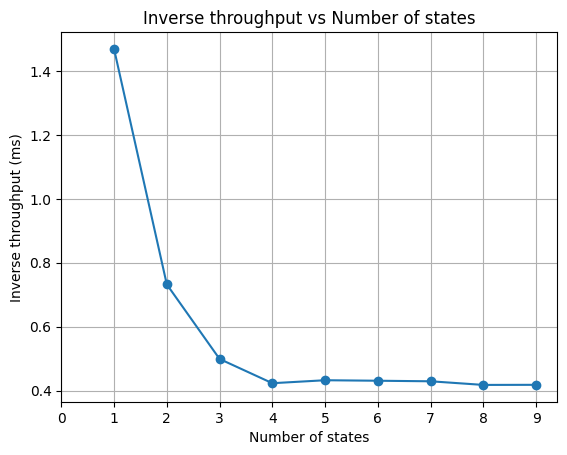

In [137]:
# plotting inv_throughput

plt.plot(range(len(inv_throughput)), inv_throughput, marker='o')
plt.xlabel("Number of states")
plt.ylabel("Inverse throughput (ms)")
plt.title("Inverse throughput vs Number of states")
plt.xticks(range(len(inv_throughput)), range(len(inv_throughput)))
plt.grid()
plt.savefig("inv_throughput.png")
plt.show()

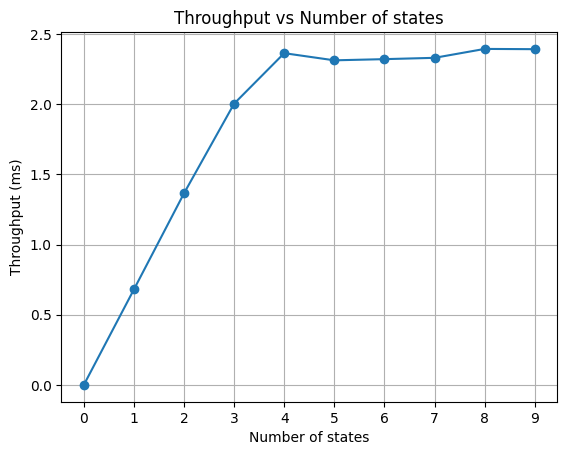

In [138]:
throughput = 1 / inv_throughput

plt.plot(range(len(throughput)), throughput, marker='o')
plt.xlabel("Number of states")
plt.ylabel("Throughput (ms)")
plt.title("Throughput vs Number of states")
plt.xticks(range(len(throughput)), range(len(throughput)))
plt.grid()
plt.savefig("throughput_vs_nstates.png")
plt.show()